In [1]:
from tqdm import tqdm
from pathlib import Path
from scipy.stats import norm
from utils.plot_utils import *
import matplotlib.pyplot as plt
from astropy import units, constants

## Velocity Broadening
The beamsource can be modelled as an extended source, spawning molecules in a 2D gaussian distribution with width $\sigma = 4.83 mm$ at 1 cm from the cell opening.  
From Oskari's beamsource characterization report the forward velocity is 184 m/s $\pm$ 16.8 m/s, width a transverse velocity $\sigma_\perp = 93/2\sqrt{2}\log{2}$ m/s.  

The Doppler shift in frequency is given by $f = f_0 \left(1+v/c\right)$, where $f_0$ is the rest frequency.

In [2]:
@units.quantity_input
def doppler_shift(v: units.m/units.s, frequency: units.Hz):
    return (frequency*(1+v/constants.c)).to(units.Hz)

In [3]:
Γ = (1/(100*units.ns)).to(units.Hz)
vp = 1*units.m/units.s
ω = (2*np.pi*constants.c/(271*units.nm)).to(units.Hz)

In [4]:
v_to_Γ = (doppler_shift(vp,ω) - ω)/Γ
print(f'1 m/s transverse velocity results in a frequency shift of {v_to_Γ:.2f} Γ')

1 m/s transverse velocity results in a frequency shift of 2.32 Γ


The rotational cooling detection scheme has 2 apertures with a radius of 4 mm, one placed before the rotational cooling chamber and another before the detection chamber.

Now spawning the molecules with random positions and velocities, drawn from gaussian distributions.

In [5]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 1.5 # m/s

v_laser = 1.5 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

In [8]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [9]:
size = int(1e7)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

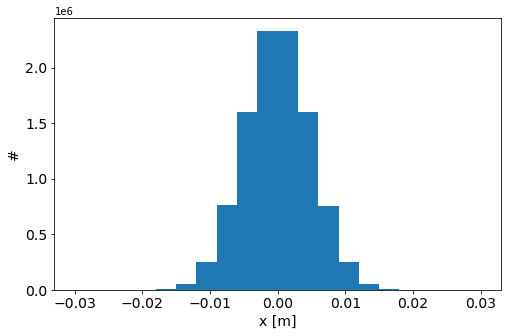

In [10]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(coords[0,:], bins = np.linspace(-0.03, 0.03, 21))
ax.set_xlabel('x [m]')
ax.set_ylabel('#')

set_fontsize(ax, 14)

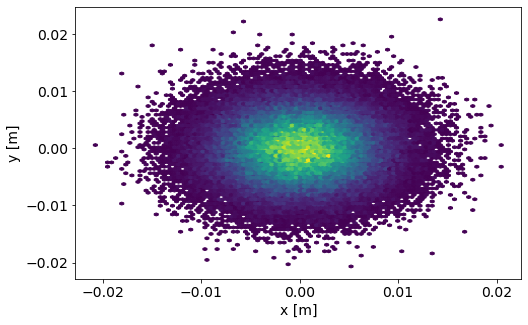

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(coords[0,:][:int(1e5)],coords[1,:][:int(1e5)], mincnt = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 14)

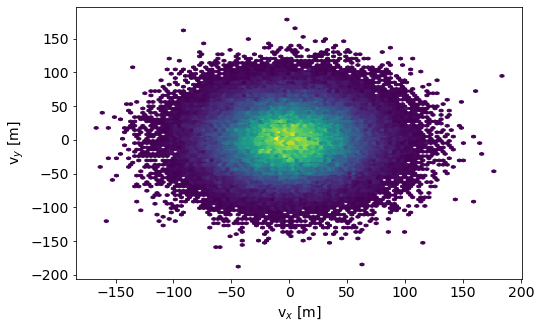

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(v_x[:int(1e5)], v_y[:int(1e5)], mincnt = 1)
ax.set_xlabel(r'v$_x$ [m]')
ax.set_ylabel(r'v$_y$ [m]')

set_fontsize(ax, 14)

### Without Aperture
Without an aperture there are several transverse velocity limiting components in the beamline.  
The closest to the rotational cooling chamber is the entrance flange, where the 1st colimator would also be placed.
The distance from the assumed extended source of this component is 17.36" - 1 cm, and the opening diameter is 60 mm.

In [13]:
in_to_m = (units.imperial.inch).to(units.m)

In [14]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]

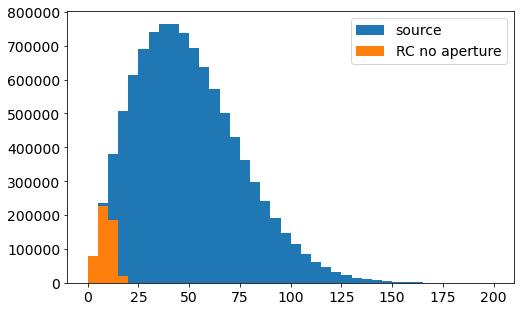

In [15]:
dx = 5
b = np.arange(0,200+dx,dx)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(v_x_full**2+v_y_full**2), bins = b, label = 'source')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = b, label = 'RC no aperture')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 35.37" 

In [16]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [17]:
distance_aperture_2 = 35.37 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [18]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)

In [19]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

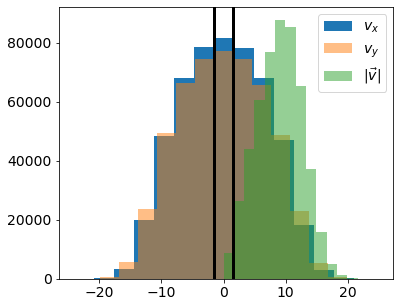

In [20]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

This figure shows the transverse velocity spread in the rotational cooling chamber.

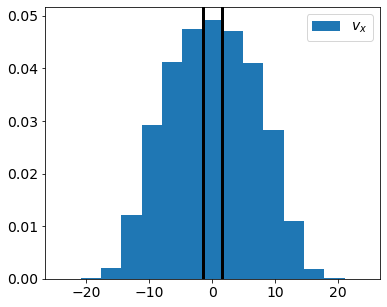

In [21]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$', density=True)

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

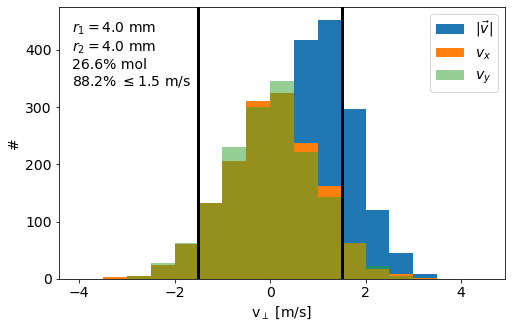

In [105]:
# calculating the velocity spread after 2 apertures
# both with an aperture radius of 4 mm

r1 = 4e-3
r2 = 4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 14, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')
ax.set_ylabel('#')

set_fontsize(ax, 14)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum()):.1f}% $\leq {v_acceptable}$ m/s'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

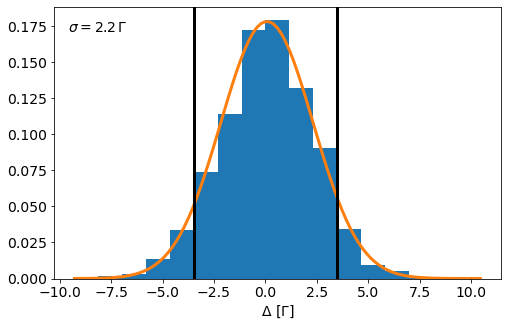

In [66]:
bins = np.arange(-4*v_to_Γ,(4+1)*v_to_Γ,0.5*v_to_Γ)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(v_x[m]*v_to_Γ, bins = bins, label = r'$v_x$', density = True)

mu, sigma = norm.fit(v_x[m]*v_to_Γ)

_x = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_x, norm.pdf(_x, mu, sigma), lw = 3)

ax.axvline(v_acceptable*v_to_Γ, lw = 3, color = 'k')
ax.axvline(-v_acceptable*v_to_Γ, lw = 3, color = 'k')

ax.set_xlabel(r'$\Delta$ [Γ]')
set_fontsize(ax, 14)

text = f'$\sigma = ${sigma:.1f}$\,$Γ'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

The transverse velocity spread that makes it to the LIF detection region in units of $\Gamma$.

# Solving the ODE system for rotational cooling with a single laser and detuning
## Loading Julia

In [24]:
from julia import Main

In [25]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")

In [26]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [27]:
# reading from file
with open('ode_fun.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [28]:
print(ode_fun[:995])


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		νp = p[2]
		Δ = p[3]
		Px = square_wave(t, νp, 3.141592653589793)
		Pz = square_wave(t, νp, 0.0)    
		du[1,1] = 3367347.38920463*ρ[37,37] + 3367525.85757619*ρ[38,38] + 3367704.32982946*ρ[39,39]
		du[1,2] = -83545.9813842773*1im*ρ[1,2]
		du[1,3] = -83566.3651428223*1im*ρ[1,3]
		du[1,4] = -83586.7483215332*1im*ρ[1,4]
		du[1,5] = 83783184618.4029*1im*ρ[1,5]
		du[1,6] = 83783324359.4973*1im*ρ[1,6]
		du[1,7] = 83783324348.7985*1im*ρ[1,7]
		du[1,8] = 83783324338.0963*1im*ρ[1,8]
		du[1,9] = 83784429890.3703*1im*ρ[1,9]
		du[1,10] = 83784429890.5489*1im*ρ[1,10]
		du[1,11] = 83784429890.728*1im*ρ[1,11]
		du[1,12] = 83784521261.0184*1im*ρ[1,12]
		du[1,13] = 83784521250.7175*1im*ρ[1,13]
		du[1,14] = 83784521240.416*1im*ρ[1,14]
		du[1,15] = 83784521230.1141*1im*ρ[1,15]
		du[1,16] = 83784521219.8117*1im*ρ[1,16]
		du[1,17] = -1.0*1im*(-0.284538010900662*Ω*ρ[1,37]*Pz - 0.201189869144348*Ω*ρ[1,38]*Px - 251351022414.089*ρ[1,17])
		


In [29]:
# defining the function in Julia
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

Loading the initial population at 7 K

In [30]:
data_dir = Path('stored_data')

fnames = ['rho_ini']

for fname in fnames:
    if fname == 'rho_ini':
        ρ_ini = np.load(data_dir / (fname + '.npy'))
    else:
        globals()[fname] = np.load(data_dir / (fname + '.npy'))

In [31]:
de_main = -0.39444661382277774 # main dipole transition moment
Γ = 1/(100e-9)
Ω =  4.5*Γ*abs(de_main)
ωp = Γ
νp = ωp/(2*np.pi)
Δ = 0

Main.Ω = Ω
Main.νp = νp
Main.Δ = Δ
Main.Γ = Γ

Main.ρ_ini = ρ_ini

Main.eval("p = [Ω, νp, Δ]")

array([17750097.622025  ,  1591549.43091895,        0.        ])

Defining the paremeters to sweep over

In [32]:
Main.eval("Omegas = (Ω/4.5)*(0.125:0.125:7)")
Main.eval("Deltas = Γ*(-10:0.25:10)")
Main.eval("params = zeros(length(Omegas)*length(Deltas),2)")
Main.eval("""
for i = 1:length(Omegas)
    for j = 1:length(Deltas)
        params[(i-1)*length(Deltas)+j,1] = Omegas[i]
        params[(i-1)*length(Deltas)+j,2] = Deltas[j] 
    end
end
""")

In [33]:
# setting up the ODEProblem to solve
Main.eval("""
tspan = (0.0f0, 240e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [34]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1],νp, params[i,2]])
end
""")

<PyCall.jlwrap prob_func>

In [35]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [36]:
# making sure multiple threads are enabled
Main.eval("Threads.nthreads()")

10

In [37]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary

Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = size(params)[1] , dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

515.537424801

In [38]:
ens_u = Main.eval("sim.u")

In [39]:
results = {}

for (Ω_factor, Δ_factor), ut_ens in tqdm(zip(Main.params,ens_u), total = len(ens_u)):
    ut_ens = np.array(ut_ens)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut_ens.shape[2]))))
    P0 = np.sum(pop_results[:4], axis = 0)
    results[(round(Ω_factor/(Ω/4.5),2), round(Δ_factor/Γ,2))] = P0[-1]

100%|████████████████████████████████████████████████████████████████████████████| 4536/4536 [00:01<00:00, 2805.45it/s]


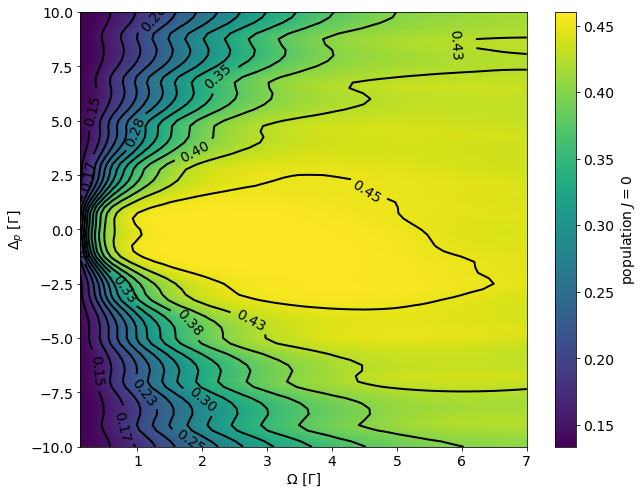

In [40]:
dim_x, dim_y = len(Main.Omegas), len(Main.Deltas)
x,y = zip(*list(results.keys()))

X = np.array(x).reshape(dim_x,dim_y)
Y = np.array(y).reshape(dim_x,dim_y)
Z = np.array(list(results.values())).reshape(dim_x,dim_y)

fig, ax = plt.subplots(figsize = (10,8))
cs = ax.pcolormesh(X,Y,Z, shading = 'gouraud')
cbar = fig.colorbar(cs)
cs = ax.contour(X,Y,Z, colors = 'k', levels = 15,
           linewidths = 2)
ax.clabel(cs, cs.levels, inline=True, fmt='%.2f', fontsize=14)


ax.set_xlabel("Ω [Γ]")
ax.set_ylabel(r"Δ [Γ]")
cbar.set_label('population $J=0$')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

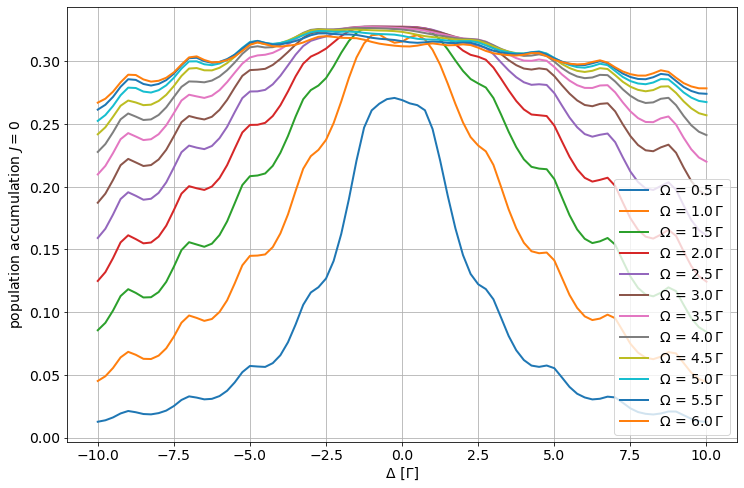

In [41]:
fig, ax = plt.subplots(figsize = (12,8))
for Ω_factor in Main.Omegas[3:50:4]:
    Ω_factor = round(Ω_factor/(Ω/4.5),2)
    
    indices = np.where(X == Ω_factor)
    
    ax.plot(Y[indices], Z[indices]-np.diag(ρ_ini.real)[:4].sum(), lw = 2, label = f'Ω = {Ω_factor:.1f}$\,$Γ')

ax.legend(fontsize = 14, loc = 4)
ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('population accumulation $J=0$')
set_fontsize(ax, 14)
ax.grid(True)

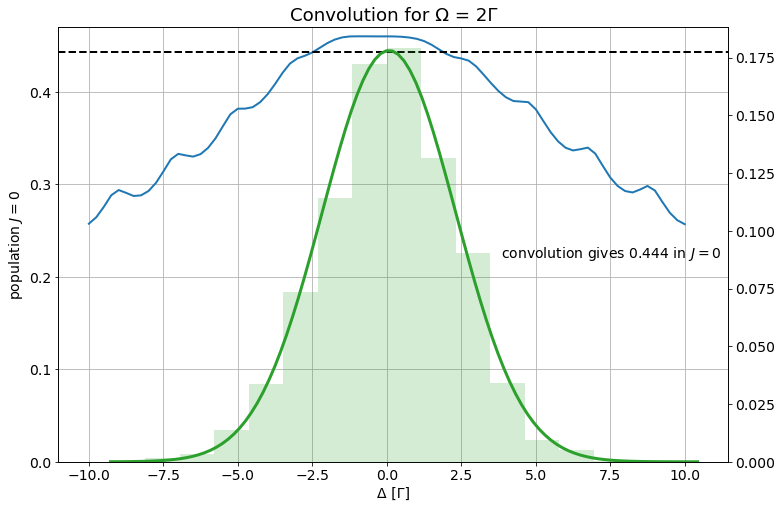

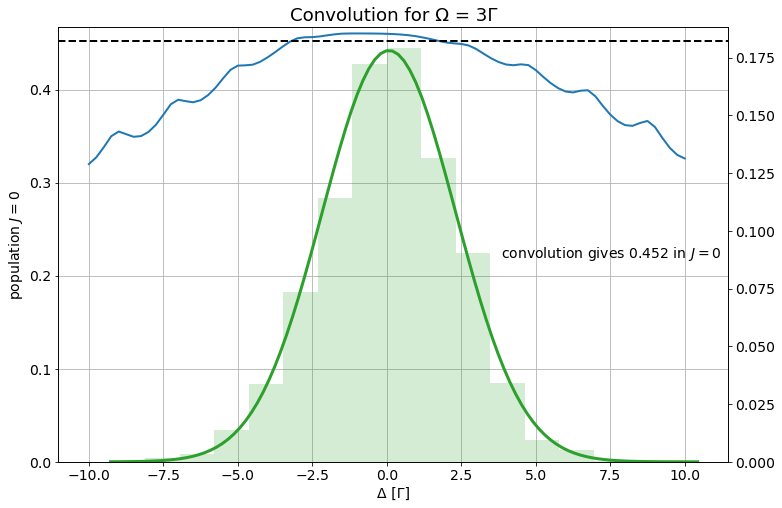

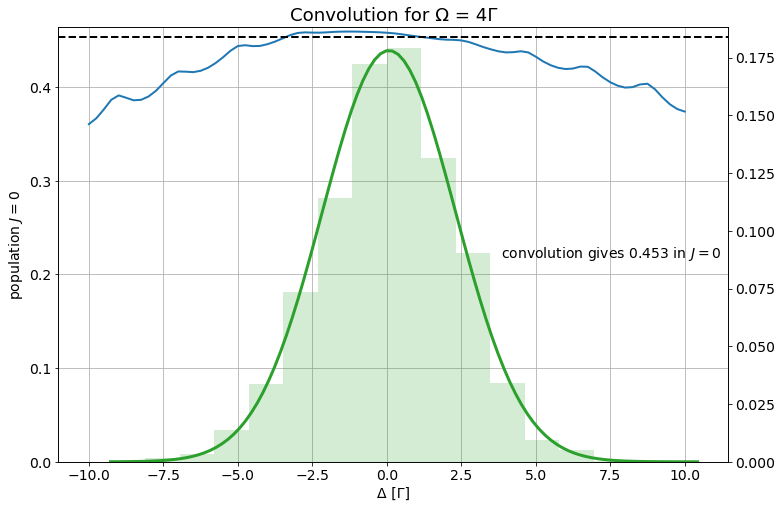

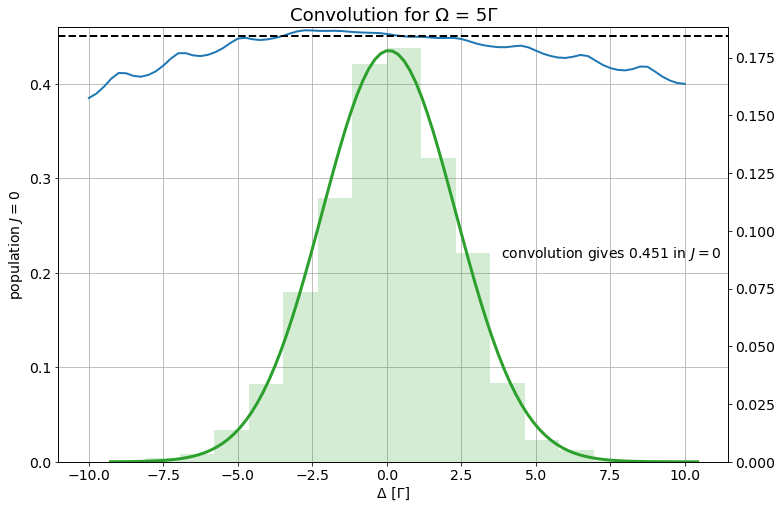

In [102]:
for Ω_factor in [2,3,4,5]:
    indices = np.where(X == Ω_factor)
    detuning, population = Y[indices], Z[indices]

    fig, ax = plt.subplots(figsize = (12,8))

    ax.plot(detuning, population, lw = '2')
    ax.set_ylim(ymin = 0)

    # convolving the velocity distribution with the measured final population
    convolved = np.sum(norm.pdf(detuning, mu, sigma)*population) * np.diff(detuning)[0]

    text = f'convolution gives {convolved:.3f} in $J=0$'
    ax.text(0.99, 0.5, text, transform = ax.transAxes,
            ha = 'right', va = 'top', fontsize = 14);
    ax.axhline(convolved, ls = '--', lw = 2, color = 'k')

    ax1 = ax.twinx()
    ax1.hist(v_x[m]*v_to_Γ, bins = bins, label = r'$v_x$', density = True, alpha = 0.2, color = 'C2')
    ax1.plot(_x, norm.pdf(_x, mu, sigma), lw = 3, color = 'C2')


    ax.set_xlabel('Δ [Γ]')
    ax.set_ylabel('population $J=0$')
    ax.set_title(f'Convolution for Ω = {Ω_factor:.0f}Γ')


    set_fontsize(ax, 14)
    set_fontsize(ax1, 14)
    ax.grid(True)